In [35]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import f, norm, pearsonr, ttest_rel

# Load data
study_name = "Obedient twins"
specification_name = "default persona"
human_file = f"{study_name} final human data values anonymized.csv"
twin_file = f"{study_name} final twins data values anonymized.csv"
df_human = pd.read_csv(human_file, header=0, skiprows=[1, 2])
df_twin = pd.read_csv(twin_file, header=0, skiprows=[1, 2])


# add new columns with relevant variables coded
# task 1 - attitude change:
for df in (df_human, df_twin):
    df["attitude_1"] = pd.to_numeric(df["attitude_1"], errors="coerce")
    df["new_att_1"] = pd.to_numeric(df["new_att_1"], errors="coerce")

    conditions = [df["attitude_1"] > 50, df["attitude_1"] < 50, df["attitude_1"] == 50]
    choices = [
        df["attitude_1"] - df["new_att_1"],
        df["new_att_1"] - df["attitude_1"],
        (df["new_att_1"] - df["attitude_1"]).abs(),
    ]

    df["task 1 - attitude_change"] = np.select(conditions, choices, default=np.nan)


# task 2 - Scenario 1:
for df in (df_human, df_twin):
    df["task 2 - S1"] = (8 - df["i1_1"].astype("Int64") + 8 - df["i1_2"].astype("Int64")) / 2

# task 2 - Scenario 2:
for df in (df_human, df_twin):
    df["task 2 - S2"] = (df["i2_1"].astype("Int64") + 8 - df["i2_2"].astype("Int64")) / 2

# task 2 - Scenario 3:
for df in (df_human, df_twin):
    df["task 2 - S3"] = (df["i3_1"].astype("Int64") + df["i3_2"].astype("Int64")) / 2

# task 3 - Scenario 1:
for df in (df_human, df_twin):
    df["task 3 - S1"] = df["a1_1"].astype("Int64")

# task 3 - Scenario 2:
for df in (df_human, df_twin):
    df["task 3 - S2"] = df["a2_1"].astype("Int64")

# task 3 - Scenario 3:
for df in (df_human, df_twin):
    df["task 3 - S3"] = df["a3_1"].astype("Int64")

out_file = f"{study_name} {specification_name} human data processed.csv"
df_human.to_csv(out_file, index=False)
out_file = f"{study_name} {specification_name} twins data processed.csv"
df_twin.to_csv(out_file, index=False)

# Compute results
results = []

#####################################################
# start with DV that doesn't have a condition:
# define relevant columns:
# condition variable names:
condition_vars = [""]
# Check if we have a real condition var
if condition_vars and condition_vars[0].strip():
    cond = condition_vars[0]
    cond_h = f"{cond}_human"
    cond_t = f"{cond}_twin"
    cond_exists = True
else:
    cond_exists = False

# different condition assignments for each DV (unique to this study)
dv_to_cond = {}

# raw responses:
raw_vars = []

# DVs:
DV_vars = ["task 1 - attitude_change"]
DV_vars_min = [-100]
DV_vars_max = [100]
# DVs: domain=social?
DV_vars_social = [1]
DV_vars_social_map = dict(zip(DV_vars, DV_vars_social))
# DVs: domain=cognitive?
DV_vars_cognitive = [0]
DV_vars_cognitive_map = dict(zip(DV_vars, DV_vars_cognitive))
# DVs: replicating know human bias?
DV_vars_known = [1]
DV_vars_known_map = dict(zip(DV_vars, DV_vars_known))
# DVs: preference measure?
DV_vars_pref = [1]
DV_vars_pref_map = dict(zip(DV_vars, DV_vars_pref))
# DVs: stimuli dependent?
DV_vars_stim = [1]
DV_vars_stim_map = dict(zip(DV_vars, DV_vars_stim))
# DVs: knowledge question?
DV_vars_know = [0]
DV_vars_know_map = dict(zip(DV_vars, DV_vars_know))
# DVs: political question?
DV_vars_politics = [1]
DV_vars_politics_map = dict(zip(DV_vars, DV_vars_politics))

# merging key
merge_key = ["TWIN_ID"]

# Merge on TWIN_ID
df = pd.merge(df_human, df_twin, on=merge_key, suffixes=("_human", "_twin"))

print("Merged df columns:", df.columns.tolist())

# Fix dtypes
for var in raw_vars + DV_vars:
    df[f"{var}_human"] = pd.to_numeric(df[f"{var}_human"], errors="coerce")
    df[f"{var}_twin"] = pd.to_numeric(df[f"{var}_twin"], errors="coerce")

# build min/max maps from both raw_vars and DV_vars
min_map = {v: mn for v, mn in zip(DV_vars, DV_vars_min)}
# min_map = {v: mn for v, mn in zip(raw_vars,      raw_vars_min)}
# min_map.update({v: mn for v, mn in zip(DV_vars,   DV_vars_min)})

max_map = {v: mx for v, mx in zip(DV_vars, DV_vars_max)}
# max_map = {v: mx for v, mx in zip(raw_vars,      raw_vars_max)}
# max_map.update({v: mx for v, mx in zip(DV_vars,   DV_vars_max)})

# now add _min and _max columns for every variable in the union
for var in min_map:
    df[f"{var}_min"] = min_map[var]
    df[f"{var}_max"] = max_map[var]


for var in DV_vars:
    # 07/18/26: condition assignment different for each DV.
    col_h = f"{var}_human"
    col_t = f"{var}_twin"
    min_col = f"{var}_min"
    max_col = f"{var}_max"
    if cond_exists:
        cols = [col_h, col_t, cond_h, cond_t, min_col, max_col]
    else:
        cols = [col_h, col_t, min_col, max_col]
    pair = df[cols].dropna(subset=[col_h, col_t])
    # # look up the right condition for this DV
    #     cond    = dv_to_cond[var]           # e.g. 'condition_green'
    #     col_h   = f"{var}_human"
    #     col_t   = f"{var}_twin"
    #     min_col = f"{var}_min"
    #     max_col = f"{var}_max"

    #     if cond:
    #         # only if there's a real condition
    #         cond_h = f"{cond}_human"
    #         cond_t = f"{cond}_twin"
    #         cols = [col_h, col_t, cond_h, cond_t, min_col, max_col]
    #         pair = df[cols].dropna(subset=[col_h, col_t, cond_h, cond_t])
    #     else:
    #         # no condition variable for this DV
    #         cols = [col_h, col_t, min_col, max_col]
    #         pair = df[cols].dropna(subset=[col_h, col_t])

    min_val = pair[min_col].iloc[0]
    max_val = pair[max_col].iloc[0]
    n = len(pair)
    if n >= 4:
        r, _ = pearsonr(pair[col_h], pair[col_t])
        z_f = np.arctanh(r)
        se = 1 / np.sqrt(n - 3)
        z_crit = norm.ppf(0.975)
        lo_z, hi_z = z_f - z_crit * se, z_f + z_crit * se
        lo_r, hi_r = np.tanh(lo_z), np.tanh(hi_z)
        z_score = z_f / se
        # Accuracy = mean absolute diff / range
        if pd.isna(min_val) or pd.isna(max_val) or max_val == min_val:
            accuracy = np.nan
        else:
            # compute mean absolute difference
            abs_diff = np.abs(pair[col_h] - pair[col_t])
            mean_abs_diff = abs_diff.mean()
            accuracy = 1 - mean_abs_diff / (max_val - min_val)

        mean_h = pair[col_h].mean()
        mean_t = pair[col_t].mean()

        # Paired t‐test
        t_stat, p_val = ttest_rel(pair[col_h], pair[col_t])

        std_h = pair[col_h].std(ddof=1)
        std_t = pair[col_t].std(ddof=1)

        # F‐test for equal variances
        df1 = df2 = n - 1
        f_stat = (std_h**2 / std_t**2) if std_t > 0 else np.nan
        # two‐tailed p‐value:
        if not np.isnan(f_stat):
            p_f = 2 * min(f.cdf(f_stat, df1, df2), 1 - f.cdf(f_stat, df1, df2))
        else:
            p_f = np.nan

        # Effect sizes (Cohen's d) across conditions
        #    For humans:
        if cond_exists and len(pair) > 3:
            levels_h = pair[cond_h].unique()
            if len(levels_h) == 2:
                g1 = pair.loc[pair[cond_h] == levels_h[0], col_h]
                g2 = pair.loc[pair[cond_h] == levels_h[1], col_h]
                n1, n2 = len(g1), len(g2)
                # pooled sd
                s_pool = np.sqrt(
                    ((n1 - 1) * g1.var(ddof=1) + (n2 - 1) * g2.var(ddof=1)) / (n1 + n2 - 2)
                )
                d_human = (g1.mean() - g2.mean()) / s_pool if s_pool > 0 else np.nan
            else:
                d_human = np.nan
        else:
            d_human = np.nan

        #    For twins:
        if cond_exists and len(pair) > 3:
            levels_t = pair[cond_t].unique()
            if cond_exists and len(levels_t) == 2:
                g1 = pair.loc[pair[cond_t] == levels_t[0], col_t]
                g2 = pair.loc[pair[cond_t] == levels_t[1], col_t]
                n1, n2 = len(g1), len(g2)
                s_pool = np.sqrt(
                    ((n1 - 1) * g1.var(ddof=1) + (n2 - 1) * g2.var(ddof=1)) / (n1 + n2 - 2)
                )
                d_twin = (g1.mean() - g2.mean()) / s_pool if s_pool > 0 else np.nan
            else:
                d_twin = np.nan
        else:
            d_twin = np.nan
    else:
        r = lo_r = hi_r = z_score = accuracy = mean_h = mean_t = t_stat = p_val = std_h = std_t = (
            f_stat
        ) = p_f = np.nan
        d_human = d_twin = np.nan

    results.append(
        {
            "study name": study_name,
            "persona specification": specification_name,
            "variable name": var,
            #        'variable type (raw response/DV)':     'DV',
            "correlation between the responses from humans vs. their twins": r,
            "CI_lower": lo_r,
            "CI_upper": hi_r,
            "z-score for correlation between humans vs. their twins": z_score,
            "accuracy between humans vs. their twins": accuracy,
            "mean_human": mean_h,
            "mean_twin": mean_t,
            "paired t-test t-stat": t_stat,
            "paired t-test p-value": p_val,
            "std_human": std_h,
            "std_twin": std_t,
            "variance test F-stat": f_stat,
            "variance test p-value": p_f,
            "effect size based on human": d_human,
            "effect size based on twin": d_twin,
            "domain=social?": DV_vars_social_map.get(var, np.nan),
            "domain=cognitive?": DV_vars_cognitive_map.get(var, np.nan),
            "replicating know human bias?": DV_vars_known_map.get(var, np.nan),
            "preference measure?": DV_vars_pref_map.get(var, np.nan),
            "stimuli dependent?": DV_vars_stim_map.get(var, np.nan),
            "knowledge question?": DV_vars_know_map.get(var, np.nan),
            "political question?": DV_vars_politics_map.get(var, np.nan),
            "sample size": n,
        }
    )
###################################################


#############################now do the DVs that have conditions:
# define relevant columns:
# condition variable names:
condition_vars = ["absurd_1", "absurd_2", "absurd_3", "s_1", "s_2", "s_3"]
# Check if we have a real condition var
if condition_vars and condition_vars[0].strip():
    cond = condition_vars[0]
    cond_h = f"{cond}_human"
    cond_t = f"{cond}_twin"
    cond_exists = True
else:
    cond_exists = False

# different condition assignments for each DV (unique to this study)
dv_to_cond = {
    #  'task 1 - attitude_change': '',
    "task 2 - S1": "s_1",
    "task 2 - S2": "s_2",
    "task 2 - S3": "s_3",
    "task 3 - S1": "absurd_1",
    "task 3 - S2": "absurd_2",
    "task 3 - S3": "absurd_3",
}

# raw responses:
raw_vars = []

# DVs:
# DV_vars=['task 1 - attitude_change','task 2 - S1','task 2 - S2','task 2 - S3','task 3 - S1','task 3 - S2','task 3 - S3']
DV_vars = ["task 2 - S1", "task 2 - S2", "task 2 - S3", "task 3 - S1", "task 3 - S2", "task 3 - S3"]
DV_vars_min = [1, 1, 1, 1, 1, 1]
DV_vars_max = [7, 7, 7, 7, 7, 7]
# DVs: domain=social?
DV_vars_social = [1] * 6
DV_vars_social_map = dict(zip(DV_vars, DV_vars_social))
# DVs: domain=cognitive?
DV_vars_cognitive = [0] * 6
DV_vars_cognitive_map = dict(zip(DV_vars, DV_vars_cognitive))
# DVs: replicating know human bias?
DV_vars_known = [1] * 6
DV_vars_known_map = dict(zip(DV_vars, DV_vars_known))
# DVs: preference measure?
DV_vars_pref = [1] * 6
DV_vars_pref_map = dict(zip(DV_vars, DV_vars_pref))
# DVs: stimuli dependent?
DV_vars_stim = [1] * 6
DV_vars_stim_map = dict(zip(DV_vars, DV_vars_stim))
# DVs: knowledge question?
DV_vars_know = [0] * 6
DV_vars_know_map = dict(zip(DV_vars, DV_vars_know))
# DVs: political question?
DV_vars_politics = [0, 0, 0, 0, 0, 0]
DV_vars_politics_map = dict(zip(DV_vars, DV_vars_politics))

# merging key
merge_key = ["TWIN_ID"]

# Merge on TWIN_ID
df = pd.merge(df_human, df_twin, on=merge_key, suffixes=("_human", "_twin"))

print("Merged df columns:", df.columns.tolist())

# Fix dtypes
for var in raw_vars + DV_vars:
    df[f"{var}_human"] = pd.to_numeric(df[f"{var}_human"], errors="coerce")
    df[f"{var}_twin"] = pd.to_numeric(df[f"{var}_twin"], errors="coerce")

# build min/max maps from both raw_vars and DV_vars
min_map = {v: mn for v, mn in zip(DV_vars, DV_vars_min)}
# min_map = {v: mn for v, mn in zip(raw_vars,      raw_vars_min)}
# min_map.update({v: mn for v, mn in zip(DV_vars,   DV_vars_min)})

max_map = {v: mx for v, mx in zip(DV_vars, DV_vars_max)}
# max_map = {v: mx for v, mx in zip(raw_vars,      raw_vars_max)}
# max_map.update({v: mx for v, mx in zip(DV_vars,   DV_vars_max)})

# now add _min and _max columns for every variable in the union
for var in min_map:
    df[f"{var}_min"] = min_map[var]
    df[f"{var}_max"] = max_map[var]

for var in DV_vars:
    # 07/18/26: condition assignment different for each DV.
    #     col_h = f"{var}_human"
    #     col_t = f"{var}_twin"
    #     min_col = f"{var}_min"
    #     max_col = f"{var}_max"
    #     if cond_exists:
    #         cols = [col_h, col_t, cond_h, cond_t,min_col,max_col]
    #     else:
    #         cols = [col_h, col_t,min_col,max_col]
    #     pair = (
    #     df[cols]
    #       .dropna(subset=[col_h, col_t])
    #     )
    # look up the right condition for this DV
    cond = dv_to_cond[var]  # e.g. 'condition_green'
    col_h = f"{var}_human"
    col_t = f"{var}_twin"
    min_col = f"{var}_min"
    max_col = f"{var}_max"

    if cond:
        # only if there's a real condition
        cond_h = f"{cond}_human"
        cond_t = f"{cond}_twin"
        cols = [col_h, col_t, cond_h, cond_t, min_col, max_col]
        pair = df[cols].dropna(subset=[col_h, col_t, cond_h, cond_t])
    else:
        # no condition variable for this DV
        cols = [col_h, col_t, min_col, max_col]
        pair = df[cols].dropna(subset=[col_h, col_t])

    min_val = pair[min_col].iloc[0]
    max_val = pair[max_col].iloc[0]
    n = len(pair)
    if n >= 4:
        r, _ = pearsonr(pair[col_h], pair[col_t])
        z_f = np.arctanh(r)
        se = 1 / np.sqrt(n - 3)
        z_crit = norm.ppf(0.975)
        lo_z, hi_z = z_f - z_crit * se, z_f + z_crit * se
        lo_r, hi_r = np.tanh(lo_z), np.tanh(hi_z)
        z_score = z_f / se
        # Accuracy = mean absolute diff / range
        if pd.isna(min_val) or pd.isna(max_val) or max_val == min_val:
            accuracy = np.nan
        else:
            # compute mean absolute difference
            abs_diff = np.abs(pair[col_h] - pair[col_t])
            mean_abs_diff = abs_diff.mean()
            accuracy = 1 - mean_abs_diff / (max_val - min_val)

        mean_h = pair[col_h].mean()
        mean_t = pair[col_t].mean()

        # Paired t‐test
        t_stat, p_val = ttest_rel(pair[col_h], pair[col_t])

        std_h = pair[col_h].std(ddof=1)
        std_t = pair[col_t].std(ddof=1)

        # F‐test for equal variances
        df1 = df2 = n - 1
        f_stat = (std_h**2 / std_t**2) if std_t > 0 else np.nan
        # two‐tailed p‐value:
        if not np.isnan(f_stat):
            p_f = 2 * min(f.cdf(f_stat, df1, df2), 1 - f.cdf(f_stat, df1, df2))
        else:
            p_f = np.nan

        # Effect sizes (Cohen's d) across conditions
        #    For humans:
        if cond_exists and len(pair) > 3:
            levels_h = pair[cond_h].unique()
            if len(levels_h) == 2:
                g1 = pair.loc[pair[cond_h] == levels_h[0], col_h]
                g2 = pair.loc[pair[cond_h] == levels_h[1], col_h]
                n1, n2 = len(g1), len(g2)
                # pooled sd
                s_pool = np.sqrt(
                    ((n1 - 1) * g1.var(ddof=1) + (n2 - 1) * g2.var(ddof=1)) / (n1 + n2 - 2)
                )
                d_human = (g1.mean() - g2.mean()) / s_pool if s_pool > 0 else np.nan
            else:
                d_human = np.nan
        else:
            d_human = np.nan

        #    For twins:
        if cond_exists and len(pair) > 3:
            levels_t = pair[cond_t].unique()
            if cond_exists and len(levels_t) == 2:
                g1 = pair.loc[pair[cond_t] == levels_t[0], col_t]
                g2 = pair.loc[pair[cond_t] == levels_t[1], col_t]
                n1, n2 = len(g1), len(g2)
                s_pool = np.sqrt(
                    ((n1 - 1) * g1.var(ddof=1) + (n2 - 1) * g2.var(ddof=1)) / (n1 + n2 - 2)
                )
                d_twin = (g1.mean() - g2.mean()) / s_pool if s_pool > 0 else np.nan
            else:
                d_twin = np.nan
        else:
            d_twin = np.nan
    else:
        r = lo_r = hi_r = z_score = accuracy = mean_h = mean_t = t_stat = p_val = std_h = std_t = (
            f_stat
        ) = p_f = np.nan
        d_human = d_twin = np.nan

    results.append(
        {
            "study name": study_name,
            "persona specification": specification_name,
            "variable name": var,
            #        'variable type (raw response/DV)':     'DV',
            "correlation between the responses from humans vs. their twins": r,
            "CI_lower": lo_r,
            "CI_upper": hi_r,
            "z-score for correlation between humans vs. their twins": z_score,
            "accuracy between humans vs. their twins": accuracy,
            "mean_human": mean_h,
            "mean_twin": mean_t,
            "paired t-test t-stat": t_stat,
            "paired t-test p-value": p_val,
            "std_human": std_h,
            "std_twin": std_t,
            "variance test F-stat": f_stat,
            "variance test p-value": p_f,
            "effect size based on human": d_human,
            "effect size based on twin": d_twin,
            "domain=social?": DV_vars_social_map.get(var, np.nan),
            "domain=cognitive?": DV_vars_cognitive_map.get(var, np.nan),
            "replicating know human bias?": DV_vars_known_map.get(var, np.nan),
            "preference measure?": DV_vars_pref_map.get(var, np.nan),
            "stimuli dependent?": DV_vars_stim_map.get(var, np.nan),
            "knowledge question?": DV_vars_know_map.get(var, np.nan),
            "political question?": DV_vars_politics_map.get(var, np.nan),
            "sample size": n,
        }
    )
################################################


# print results:

# results DataFrame
corr_df = pd.DataFrame(results)
print(corr_df)

# save output as csv - unit of observation is comparison between humans and twins:
out_file = f"{study_name} {specification_name} meta analysis.csv"
corr_df.to_csv(out_file, index=False)

##### participant‐level data (only rows where the DV value is NOT NaN) #####

# combine all DVs
DV_vars = [
    "task 1 - attitude_change",
    "task 2 - S1",
    "task 2 - S2",
    "task 2 - S3",
    "task 3 - S1",
    "task 3 - S2",
    "task 3 - S3",
]


def make_long(df, respondent_type):
    # pick off TWIN_ID + the DVs, then melt
    long = df[["TWIN_ID"] + DV_vars].melt(
        id_vars="TWIN_ID", value_vars=DV_vars, var_name="variable_name", value_name="value"
    )
    long["respondent_type"] = respondent_type
    long["study_name"] = study_name
    long["specification_name"] = specification_name
    return long


# build the two halves
long_h = make_long(df_human, "human")
long_t = make_long(df_twin, "twin")

# stack them and keep only non-NaN values
df_long = pd.concat([long_h, long_t], ignore_index=True)
df_long = df_long[df_long["value"].notna()]

print(df_long.head())

# save output as csv - unit of observation is TWIN_ID (only non-NaNs)
out_file = f"{study_name} {specification_name} meta analysis individual level.csv"
df_long.to_csv(out_file, index=False)

print("done")

Merged df columns: ['StartDate_human', 'EndDate_human', 'Progress_human', 'Duration (in seconds)_human', 'Finished_human', 'RecordedDate_human', 'consent non_twins_human', 'consent twins_human', 'Q57_human', 'Q4_First Click_human', 'Q4_Last Click_human', 'Q4_Page Submit_human', 'Q4_Click Count_human', 'attitude_1_human', 'argument_human', 'new_att_1_human', 'i1_1_human', 'i1_2_human', 'i2_1_human', 'i2_2_human', 'i3_1_human', 'i3_2_human', 'a1_1_human', 'a2_1_human', 'a3_1_human', 'side1_human', 'side2_human', 'side3_human', 'side 2_human', 'absurd_1_human', 'absurd_2_human', 'absurd_3_human', 's_1_human', 's_2_human', 's_3_human', 'FL_42_DO_FL_29_human', 'FL_42_DO_FL_43_human', 'FL_6_DO_FL_7_human', 'FL_6_DO_FL_8_human', 'FL_15_DO_FL_16_human', 'FL_15_DO_FL_17_human', 'FL_12_DO_FL_13_human', 'FL_12_DO_FL_14_human', 'FL_50_DO_FL_51_human', 'FL_50_DO_FL_52_human', 'FL_59_DO_FL_60_human', 'FL_59_DO_FL_61_human', 'FL_56_DO_FL_57_human', 'FL_56_DO_FL_58_human', 'Imagine1_DO_i1_2_human', 'I

In [36]:
# TASK 1
import statsmodels.formula.api as smf

# ─── Prepare and clean the model data ───────────────────────────────────────────

# Combine human and twin, rename DV, tag twin_type
df_human_model = (
    df_human[["TWIN_ID", "task 1 - attitude_change", "attitude_1"]]
    .rename(columns={"task 1 - attitude_change": "attitude_change"})
    .assign(twin_type="human")
)
df_twin_model = (
    df_twin[["TWIN_ID", "task 1 - attitude_change", "attitude_1"]]
    .rename(columns={"task 1 - attitude_change": "attitude_change"})
    .assign(twin_type="digital")
)
df_model = pd.concat([df_human_model, df_twin_model], ignore_index=True)

# Cast to float so missing become np.nan, then drop any rows with NA
df_model["attitude_change"] = df_model["attitude_change"].astype(float)
df_model["attitude_1"] = df_model["attitude_1"].astype(float)
df_model = df_model.dropna(subset=["attitude_change", "attitude_1"])

# Make twin_type a categorical
df_model["twin_type"] = df_model["twin_type"].astype("category")

# ─── Fit the mixed‐effects model ───────────────────────────────────────────────
# Use missing='drop' just in case, but since we dropped above it's optional
md = smf.mixedlm(
    "attitude_change ~ C(twin_type) + attitude_1",
    df_model,
    groups=df_model["TWIN_ID"],
    missing="drop",
)
mdf = md.fit(reml=False)

print(mdf.summary())

            Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: attitude_change
No. Observations:  2002    Method:             ML             
No. Groups:        1001    Scale:              109.4577       
Min. group size:   2       Log-Likelihood:     -7546.1148     
Max. group size:   2       Converged:          Yes            
Mean group size:   2.0                                        
--------------------------------------------------------------
                      Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept             0.246    0.573 0.429 0.668 -0.878  1.370
C(twin_type)[T.human] 3.450    0.468 7.374 0.000  2.533  4.367
attitude_1            0.041    0.007 5.460 0.000  0.026  0.055
Group Var             0.568    0.334                          



In [32]:
# TASK 2:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf


# ─── 3. Stack scenarios into long form ─────────────────────────────────────────
def stack_scenarios(df, twin_label):
    long = df.melt(
        id_vars=["TWIN_ID", "s_1", "s_2", "s_3"],
        value_vars=["task 2 - S1", "task 2 - S2", "task 2 - S3"],
        var_name="scenario",
        value_name="score",
    )
    # extract scenario number (1,2,3)
    long["scenario"] = long["scenario"].str[-1].astype(int)
    # pull in the matching manipulation (test/control)
    long["manipulation"] = long.apply(lambda r: r[f"s_{r.scenario}"], axis=1)
    long["twin_type"] = twin_label
    return long


long_h = stack_scenarios(df_human, "human")
long_t = stack_scenarios(df_twin, "digital")
df_long = pd.concat([long_h, long_t], ignore_index=True)

# ─── 4. Clean and prepare design variables ────────────────────────────────────
df_long["score"] = pd.to_numeric(df_long["score"], errors="coerce")
df_long["manipulation"] = df_long["manipulation"].astype("category")
df_long["twin_type"] = df_long["twin_type"].astype("category")
df_long = df_long.dropna(subset=["score", "manipulation"])

# Create two dummy columns for scenario random‐effects (scenario 2 & 3;
# scenario 1 is the reference)
df_long["sc2"] = (df_long["scenario"] == 2).astype(float)
df_long["sc3"] = (df_long["scenario"] == 3).astype(float)

# ─── 5. Fit the linear mixed‐effects model ────────────────────────────────────
#    DV:     score
#    IVs:    manipulation (test vs. control), twin_type (human vs. digital),
#             and their interaction
#    REs:    random intercept by TWIN_ID, plus scenario-specific intercepts
md = smf.mixedlm(
    "score ~ C(manipulation) * C(twin_type)",
    df_long,
    groups=df_long["TWIN_ID"],
    vc_formula={"sc2": "0 + sc2", "sc3": "0 + sc3"},
)
mdf = md.fit(reml=False)

# ─── 6. View the results ───────────────────────────────────────────────────────
print(mdf.summary())


# COMPARE MEANS:
import pandas as pd

# ─── (If you haven’t already) build df_long ────────────────────────────────────
# long = pd.concat([long_h, long_t], ignore_index=True)
# where `long_h`/`long_t` were created by your stack_scenarios() function,
# so that `long` has columns: TWIN_ID, scenario, score, manipulation (test/control), twin_type.

# ─── 1. Compute summary stats by group ─────────────────────────────────────────
# Group by twin_type (“human”/“digital”) and manipulation (“test”/“control”),
# then compute mean and std of the scenario‐level score:
stats = (
    df_long.groupby(["twin_type", "manipulation"])["score"]
    .agg(avg_score="mean", sd_score="std")
    .reset_index()
)

print(stats)

                         Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           score     
No. Observations:            6006              Method:                       ML        
No. Groups:                  1001              Scale:                        1.3355    
Min. group size:             6                 Log-Likelihood:               -9997.2860
Max. group size:             6                 Converged:                    Yes       
Mean group size:             6.0                                                       
---------------------------------------------------------------------------------------
                                              Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                     2.601    0.033 78.170 0.000  2.536  2.666
C(manipulation)[T.test]                       0.357    0.

C:\Users\ot2107\AppData\Local\Temp\ipykernel_4524\3719534518.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['twin_type','manipulation'])['score']


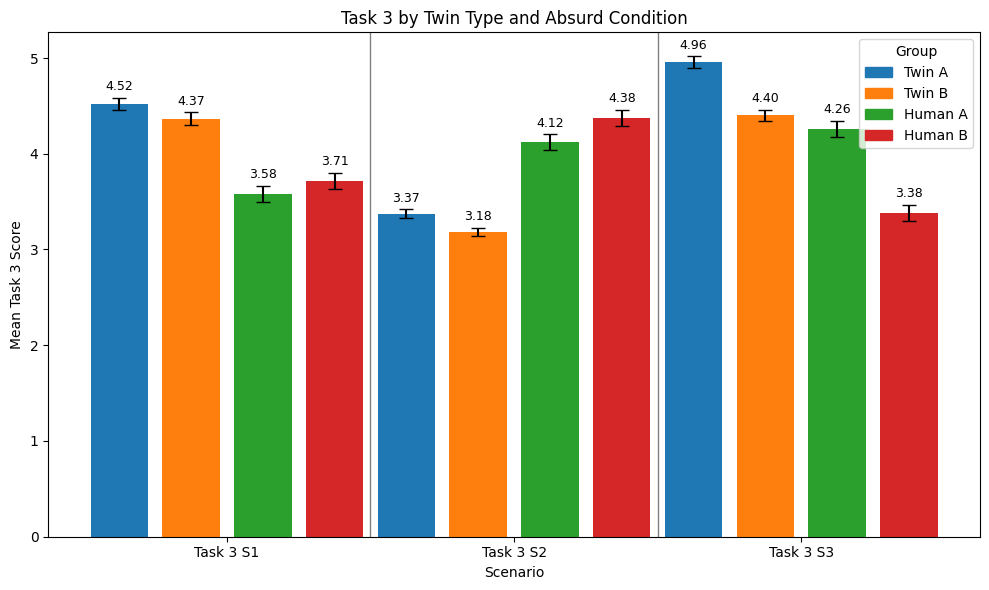

In [33]:
# TASK 3:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# ─── 1. Prepare a long‐form DataFrame for task 3 ────────────────────────────────
def stack_task3(df, twin_label):
    long = df.melt(
        id_vars=["TWIN_ID", "absurd_1", "absurd_2", "absurd_3"],
        value_vars=["task 3 - S1", "task 3 - S2", "task 3 - S3"],
        var_name="scenario",
        value_name="score",
    )
    long["scenario"] = long["scenario"].str[-1].astype(int)
    long["absurd_cond"] = long.apply(lambda r: r[f"absurd_{r.scenario}"], axis=1)
    long["twin_type"] = twin_label
    return long


long_human = stack_task3(df_human, "human")
long_twin = stack_task3(df_twin, "twin")
df_long3 = pd.concat([long_twin, long_human], ignore_index=True)

df_long3["score"] = pd.to_numeric(df_long3["score"], errors="coerce")
df_long3 = df_long3.dropna(subset=["score", "absurd_cond"])

# ─── 2. Compute means & SEMs ───────────────────────────────────────────────────
grouped = df_long3.groupby(["scenario", "twin_type", "absurd_cond"])["score"]
stats = grouped.agg(mean="mean", sem="sem").reset_index()

orders = []
for sc in [1, 2, 3]:
    for tt in ["twin", "human"]:
        for cond in ["A", "B"]:
            orders.append((sc, tt, cond))

means = [
    stats.loc[
        (stats["scenario"] == sc) & (stats["twin_type"] == tt) & (stats["absurd_cond"] == cond),
        "mean",
    ].values[0]
    for sc, tt, cond in orders
]
sems = [
    stats.loc[
        (stats["scenario"] == sc) & (stats["twin_type"] == tt) & (stats["absurd_cond"] == cond),
        "sem",
    ].values[0]
    for sc, tt, cond in orders
]

color_map = {("twin", "A"): "C0", ("twin", "B"): "C1", ("human", "A"): "C2", ("human", "B"): "C3"}

# ─── 3. Plot with error bars and annotate means ────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(orders))

for i, (sc, tt, cond) in enumerate(orders):
    ax.bar(x[i], means[i], yerr=sems[i], capsize=5, color=color_map[(tt, cond)])
    # annotate the mean value above each bar
    ax.text(
        x[i],
        means[i] + sems[i] + 0.05,  # position just above the error bar
        f"{means[i]:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# separators between scenario groups
for sep in [4, 8]:
    ax.axvline(sep - 0.5, color="gray", linewidth=1)

ax.set_xticks([1.5, 5.5, 9.5])
ax.set_xticklabels(["Task 3 S1", "Task 3 S2", "Task 3 S3"])
ax.set_xlabel("Scenario")
ax.set_ylabel("Mean Task 3 Score")
ax.set_title("Task 3 by Twin Type and Absurd Condition")

# custom legend
handles = [
    mpatches.Patch(color=color_map[(tt, cond)], label=f"{tt.capitalize()} {cond}")
    for tt, cond in [("twin", "A"), ("twin", "B"), ("human", "A"), ("human", "B")]
]
ax.legend(handles=handles, title="Group")

plt.tight_layout()
plt.show()